In [2]:
import torch
import torchvision
import torchvision.transforms.v2 as transformers

import numpy as np
import pandas as pd
import seaborn as sns

from transformers import CLIPModel
from transformers import AutoProcessor

#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

from collections import OrderedDict

In [2]:
from EDFunctions import *

In [3]:
images, targets = get_ciafar10_data()


/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
image_embeddings = np.load('2d_embeddings.npy')

In [5]:
def get_class_embeddings(embeddings, targets, label):
    #print(f'embeddings shape {embeddings.shape}')
    targets = np.array(targets)
    targets = np.expand_dims(targets, 1)

    all_indexes = np.array(range(0, embeddings.shape[0]))
    all_indexes = np.expand_dims(all_indexes, 1)

    full_data = np.append(embeddings, all_indexes, axis=1) 
    #print(f'full_data shape: {full_data.shape}')
    #print(f'all_indexes shape: {all_indexes.shape}')
    full_data = np.append(full_data, targets, axis=1) 

    #print(f'full_data shape: {full_data.shape}')

    class_data = full_data[ full_data[:,-1] == label ]
    true_indexes = class_data[:,-2].astype(int)
    #true_indexes = true_indexes[:]
    #print(true_indexes)
    class_data = class_data[:,:-2]



    return class_data, true_indexes


#expects data to be in shape (m x d)
def fit_distribution(data_points):
    mu = np.mean(data_points, axis=0)
    covar = np.cov(data_points, rowvar=False)
    diag = np.diagonal(covar)
    sd = np.sqrt(diag)
    new_dist = (class_data - mu)/sd
    return mu, covar, new_dist


import scipy.stats as st
import scipy.linalg
def get_points_outside(dist, percentage=0.5):
    radius = np.abs(st.norm.ppf(percentage/2))
    #print(radius)

    norms = np.linalg.norm(dist, axis=1)
    indexes = np.array(range(0,dist.shape[0]))
    return indexes[ norms > radius]

def get_points_inside(dist, percentage=0.5):
    radius = np.abs(st.norm.ppf((1 - percentage)/2))
    #print(f'radius {radius}')

    norms = np.linalg.norm(dist, axis=1)
    indexes = np.array(range(0,dist.shape[0]))
    return indexes[ norms < radius ]
    

def get_points(dist, percentage=0.5, where='inside'):
    if (where == 'inside'):
        radius = np.abs(st.norm.ppf((1 - percentage)/2))

        norms = np.linalg.norm(dist, axis=1)
        print(f'norms.shape: {norms.shape}')
        print(f'norms.ndim: {norms.ndim}')
        print(f'norms: {norms}')
        indexes = np.array(range(0,dist.shape[0]))
        return indexes[ norms < radius ]

    elif (where == 'outside'):
        radius = np.abs(st.norm.ppf(percentage/2))

        norms = np.linalg.norm(dist, axis=1)
        indexes = np.array(range(0,dist.shape[0]))
        return indexes[ norms > radius]

    else: 
        raise Exception(f'{where} is not a valid argument')


def fit_distribution_2(data_points):
    mu = np.mean(data_points, axis=0)
    covar = np.cov(data_points, rowvar=False)
    # the following is taken from chatgpt
    centered = data_points - mu
    L = np.linalg.cholesky(covar)
    print(f'cholesky: {L}')

    normalized_data = np.matmul(np.linalg.inv(L), np.transpose(centered))
    normalized_data = normalized_data.T

    normalized_mean = np.mean(normalized_data, axis=0)
    normalized_cov = np.cov(normalized_data, rowvar=False)

    return normalized_mean, normalized_cov, normalized_data


# idea behind this code comes from 
# https://math.stackexchange.com/questions/1652545/multivariate-normal-value-standardization
from sklearn.preprocessing import power_transform
def fit_distribution_3(data_points, transform=True):
    if (transform):
        data_points = power_transform(data_points)

    mu = np.mean(data_points, axis=0)
    sigma = np.cov(data_points, rowvar=False)
    # the following is taken from chatgpt
    centered = data_points - mu
    sigma_inv_sqrt = scipy.linalg.sqrtm(np.linalg.inv(sigma))
    L = sigma_inv_sqrt
    #print(f'simga^(-1/2): {L}')


    normalized_data = np.matmul((L), np.transpose(centered))
    normalized_data = normalized_data.T

    normalized_mean = np.mean(normalized_data, axis=0)
    normalized_cov = np.cov(normalized_data, rowvar=False)

    #print(normalized_data.shape)

    return normalized_mean, normalized_cov, normalized_data



# returns a list of list of indexes
# each entry in the list contains all the indexes used in that class for the partition
def get_all_partitions(embeddings, targets, labels, percentage, where, transform=False):
    partitions = []
    for l in labels:
        class_data, true_indexes = get_class_embeddings(embeddings, targets, l)
        num_class_points = class_data.shape[0]

        _, _, standardized_data = fit_distribution_3(class_data, transform)


        print(f'standardized_data shape {standardized_data.shape}')

        points = get_points(standardized_data, percentage, where)
        num_points_selected = points.shape[0]

        print(f'points shape {points.shape}')

        print(f'{num_points_selected/num_class_points}% points selected for class {l}')

        
        selected_indexes = []

        points = points.astype(int)
        true_indexes = true_indexes.astype(int)

        for x in points:
            selected_indexes.append(true_indexes[x])

        selected_indexes = selected_indexes
        partitions.append(selected_indexes)
    
    return partitions

        
def get_all_quantiles(embeddings, targets, labels, percentage, where, transform=True):
    quantiles = np.full((len(targets)), -1, dtype=float)
    for l in labels:
        class_data, true_indexes = get_class_embeddings(embeddings, targets, l)
        num_class_points = class_data.shape[0]

        mean, _, standardized_data = fit_distribution_3(class_data, transform)

        distance_list = []
        for i in range(num_class_points):
            distance = calc_distance(standardized_data[i, :],  mean)
            distance_list.append( (distance, true_indexes[i]) )

        sorted_distances = sorted(distance_list, key=lambda x: x[0])

        prev_index = 0
        for i in np.arange(0.001, 1.001, 0.001):
            list_index = round(i * num_class_points)
            quantile_points = sorted_distances[prev_index:list_index]

            for point in quantile_points:
                true_index = point[1]
                quantiles[true_index] = i

            prev_index = list_index



    return quantiles
            



#class_data, true_indexes = get_class_embeddings(image_embeddings, targets, 0)
#print(f'cd shape: {class_data.shape}')
#print(true_indexes)
#mu, covar, new_d = fit_distribution_3(class_data, True)

#point_indexes = get_points_inside(new_d, 0.50)
#print(point_indexes.shape[0])

#plot_batch_elements(new_d, point_indexes)
#plt.show()


#class_data, true_indexes = get_class_embeddings(image_embeddings, targets, 0)
#mu, covar, new_d = fit_distribution_3(class_data, True)

#point_indexes = get_points_inside(new_d, 0.50)
#print(point_indexes.shape)

#plot_batch_elements(new_d, point_indexes)
#plt.show()

#class_data = get_class_embeddings(image_embeddings, targets, 3)
#mu, covar, new_d = fit_distribution_2(class_data)

#point_indexes = get_points_inside(new_d, 0.70)
#print(point_indexes.shape)

#plot_batch_elements(new_d, point_indexes)
#plt.show()


In [12]:

labels = np.array(range(0, 10))

quantiles = get_all_quantiles(image_embeddings, targets, labels, 0.73, "inside", True)
print(quantiles)
np.save("quantiles001.npy", quantiles)

[0.828 0.185 0.653 ... 0.402 0.079 0.991]


[    0     4     6 ... 59992 59995 59999]


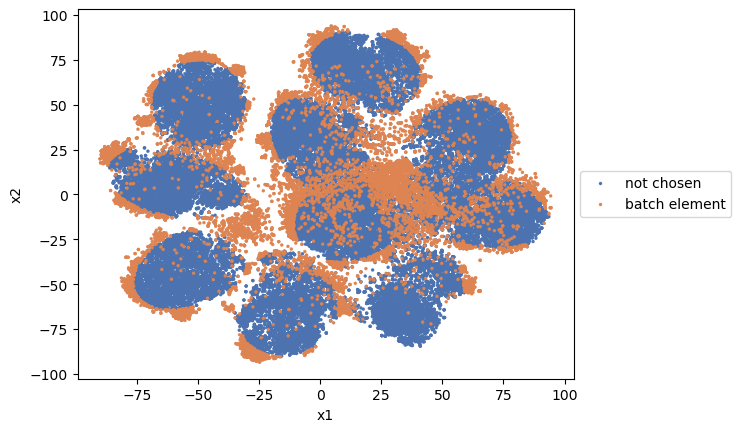

In [11]:
mask = quantiles > 0.80
all_indexes = np.arange(0, len(targets))
selected_indexes = (all_indexes[mask])
print((selected_indexes))
fig = plot_batch_elements(image_embeddings, selected_indexes, tick_size=5)

standardized_data shape (6000, 2)
norms.shape: (6000,)
norms.ndim: 1
norms: [0.83586518 0.13270264 1.42281376 ... 0.36314939 1.61803244 1.60926745]
points shape (2638,)
0.43966666666666665% points selected for class 0
standardized_data shape (6000, 2)
norms.shape: (6000,)
norms.ndim: 1
norms: [1.73009302 1.4659527  2.6705079  ... 1.22772385 0.53797436 3.23956836]
points shape (2240,)
0.37333333333333335% points selected for class 1
standardized_data shape (6000, 2)
norms.shape: (6000,)
norms.ndim: 1
norms: [0.81147736 1.45681663 1.36860858 ... 0.93557405 1.72909029 1.81315867]
points shape (2577,)
0.4295% points selected for class 2
standardized_data shape (6000, 2)
norms.shape: (6000,)
norms.ndim: 1
norms: [1.69418573 0.37941517 0.57339578 ... 1.01083186 1.95401253 0.61694663]
points shape (2487,)
0.4145% points selected for class 3
standardized_data shape (6000, 2)
norms.shape: (6000,)
norms.ndim: 1
norms: [0.39084215 1.40452067 1.79484103 ... 0.3282038  0.81347758 1.24688194]
points

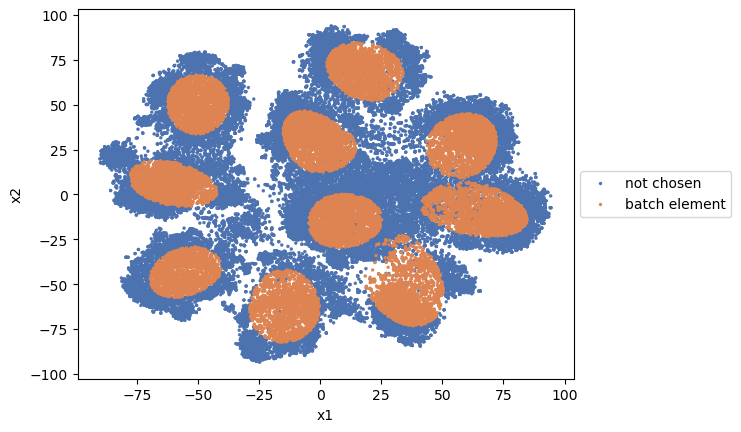

In [7]:
labels = np.array(range(0, 10))

indexes = get_all_partitions(image_embeddings, targets, labels, 0.73, "inside", True)
all_indexes = []
for l in indexes:
    all_indexes.extend(l)

#print(type(all_indexes[0][0]))

selected_images = images[all_indexes]

selected_targets = np.array(targets)[all_indexes]


np.save('partitioned_images.npy', np.array(selected_images))
np.save('partitioned_targets.npy', np.array(selected_targets))

print('here')
print((all_indexes))

fig = plot_batch_elements(image_embeddings, all_indexes, tick_size=5)

In [130]:
labels = np.array(range(0, 10))

clip_embeddings = np.load('cifar10_clip_embeddings.npy')

indexes = get_all_partitions(clip_embeddings, targets, labels, 0.999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999, "inside", True)
all_indexes = []
for l in indexes:
    all_indexes.extend(l)

#print(type(all_indexes[0][0]))

print('here')
print((all_indexes))

fig = plot_batch_elements(clip_embeddings, all_indexes, tick_size=5)

(6000, 512)
standardized_data shape (6000, 512)
norms.shape: (6000,)
norms.ndim: 1
norms: [37.42456599 16.83607314 26.73059199 23.33392687 21.94091819 23.70327729
 26.74360698 19.58285895 24.09811175 21.81121859 28.06078055 14.96658377
 25.73200866 20.55321857 17.14316336 25.86319027 22.36069363 24.85325707
 28.55994359 27.84974001 18.57716991 19.51168639 14.97118799 25.45700213
 20.29768374 24.69635467 24.24559626 23.6138686  24.84940289 27.10124096
 21.90069088 26.33687768 34.0692904  26.88351888 20.28443675 30.06709281
 23.48962537 21.29888261 17.50990415 22.31899564 20.309559   18.15527112
 27.07086363 22.13196718 25.68080757 17.51491158 19.73692515 19.78945087
 21.72809581 25.04511822 17.07752378 23.29213594 17.85792107 20.79749074
 27.20277478 20.97264331 18.66075826 25.33424057 22.16449479 26.69430645
 19.74037313 25.92613144 27.59932398 17.59056    20.65998752 17.97968633
 19.75063359 19.35520094 23.87321569 24.41100712 36.35484995 29.46714877
 21.1822478  30.15462159 33.877468

ValueError: Shape of passed values is (60000, 512), indices imply (60000, 2)

In [7]:
import sys
import numpy
numpy.set_printoptions(threshold = sys.maxsize)
#numpy.set_printoptions(threshold= False)

In [8]:
image_embeddings_slice = image_embeddings[:1000][:][:][:]

#distances = calc_distances(image_embeddings_slice)
#sorted_distances = sort_distances(distances)

batch_size = 100

#batch_indexes = generate_indexes_proportional(image_embeddings_slice, sorted_distances, batch_size, seed=None)
#batch_indexes = generate_indexes_proportional_avg(image_embeddings_slice, batch_size)#, seed=1)
batch_indexes = generate_indexes_proportional_avg(image_embeddings_slice, batch_size, power=10, seed=1)

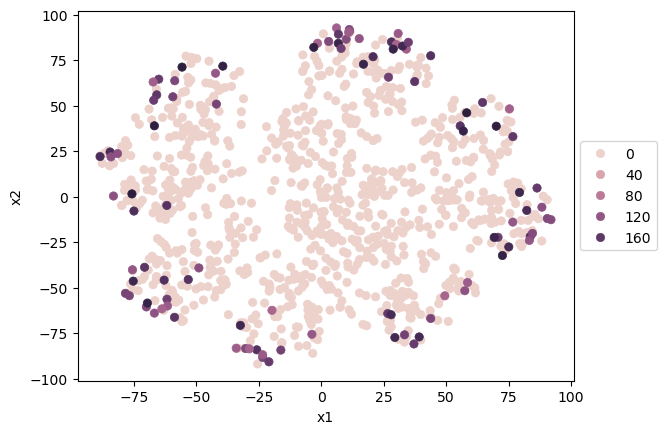

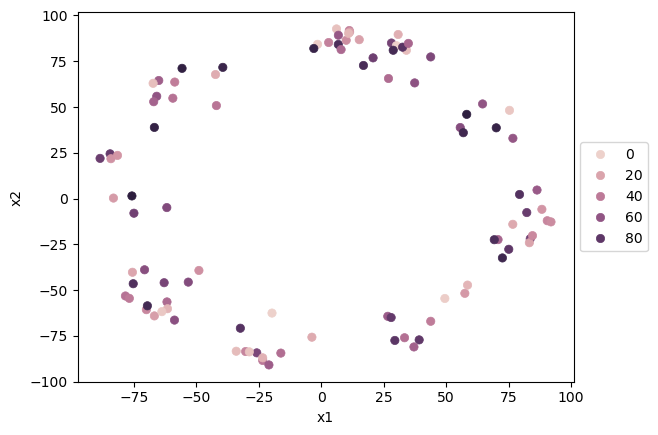

<class 'matplotlib.figure.Figure'>


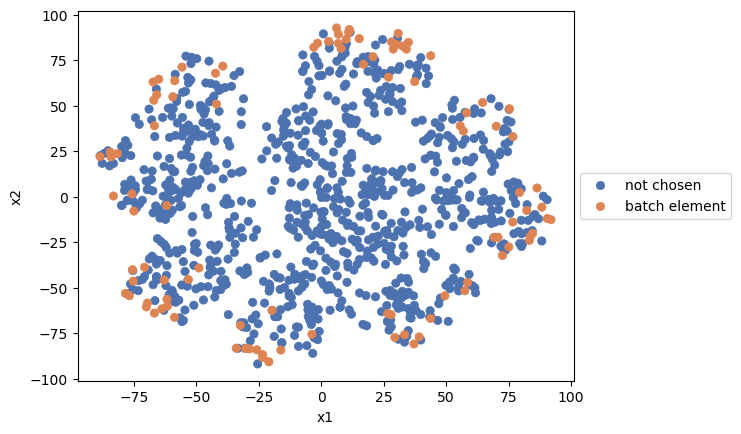

In [9]:
fig1 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='inclusive')
#plt.close()
plt.show()
fig2 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='exclusive')
#plt.close()
plt.show()
fig3 = plot_batch_elements(image_embeddings_slice,batch_indexes)
print(type(fig2))
plt.show()

10


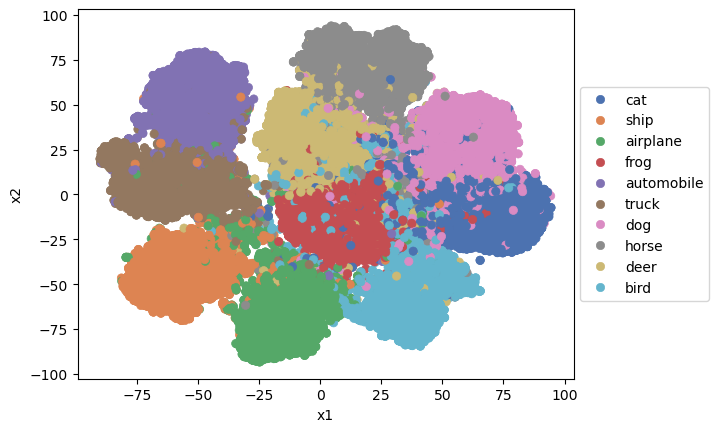

In [10]:
b = plot_classes_2d(image_embeddings, targets)
